# Allo-HCT Survival Prediction (100d, 1y, 2y, 3y)

This notebook loads  Excel file, builds features, trains nested-CV models for each horizon, and reports AUROC/AUPRC and classification metrics with ROC/PR/Calibration plots.

In [1]:
import sys
import glob, os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

In [2]:
# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [ ]:
import os, warnings, math, json
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_curve,
    roc_curve
)
from sklearn.calibration import calibration_curve
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter


from allosurv.allosurv import make_preprocessor, make_models_and_grids, make_labels, evaluate, plot_roc_pr_cal, plot_shap_for_horizon

In [4]:
DATA_PATH = 'C:\\workspace_dl\\data\\external\\Aryans\\Altered_10-12-2025.xlsx'
SHEET = None
HORIZONS = {'100d':100,'1y':365,'2y':730,'3y':1095}

In [5]:
# ==== Load ====
if SHEET is None:
    xls = pd.ExcelFile(DATA_PATH)
    SHEET = xls.sheet_names[0]
df = pd.read_excel(DATA_PATH, sheet_name=SHEET)
df['vital_status'] = pd.to_numeric(df['vital_status'], errors='coerce').fillna(0).astype(int)
df['survival_days'] = pd.to_numeric(df['survival_days'], errors='coerce')
print('Loaded', df.shape, 'sheet:', SHEET)

Loaded (500, 51) sheet: Sheet1


In [6]:
df = pd.read_csv(here() / config.data_processed / "Aryans_Top25medications_processed.csv")

In [7]:
df

,record_id,pat_gender,pat_ethnicity,vital_status,survival_days,disease_category,transplant_age,stem_cell_source,donor_type,recipient_type,...,potassiumchloride,amlodipine,lorazepam,melatonin,loperamide,ursodiol,acetaminophen,olanzapine,polyethyleneglycol,gabapentin
0,1,0,Not Hispanic or Latino (Race:Black or African ...,0,211,Severe aplastic anemia (SAA),12,MRD,A+,O+,...,0,0,1,0,0,0,1,0,0,0
1,2,1,Not Hispanic or Latino (Race:White),0,210,Acute lymphoblastic leukemia (ALL),37,MUD,O+,O+,...,0,0,1,0,0,1,0,0,0,0
2,3,0,Hispanic or Latino (Race:White),0,210,Acute Myeloid Leukemia (AML),71,MUD,O+,A+,...,0,0,0,1,0,0,0,1,0,0
3,4,1,Not Hispanic or Latino (Race:White),0,208,Non-Hodgkin lymphoma (NHL),64,MUD,A+,O+,...,1,0,0,0,0,1,0,0,0,0
4,5,1,Not Hispanic or Latino (Race:White),0,204,Acute Myeloid Leukemia (AML),50,MRD,O+,O-,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,1,Not Hispanic or Latino (Race:White),1,50,Myelodysplastic syndrome (MDS),66,MUD,B-,O-,...,1,0,0,0,0,0,0,0,0,1
496,497,1,Not Hispanic or Latino (Race:White),0,2317,Acute Myeloid Leukemia (AML),43,HRD,O+,A+,...,1,0,1,0,0,0,0,1,0,0
497,498,1,Not Hispanic or Latino (Race:White),1,44,Acute Myeloid Leukemia (AML),44,MUD,A+,O+,...,0,0,0,0,0,0,1,1,1,0
498,499,0,Not Hispanic or Latino (Race:Black or African ...,0,2309,Acute lymphoblastic leukemia (ALL),38,MUD,O+,O-,...,0,0,0,1,0,0,0,0,0,0


In [8]:
cat_cols = ['pat_gender','pat_ethnicity','disease_category','stem_cell_source','donor_type','recipient_type','conditioning_type',
            'acyclovir', 'fluconazole', 'sulfamethoxazole-trimethoprim',
       'tacrolimus', 'mycophenolatemofetil', 'ondansetron', 'sirolimus',
       'letermovir', 'prochlorperazine', 'pantoprazole', 'magnesiumoxide',
       'multivitamin/supplement', 'oxycodone', 'promethazine',
       'cholecalciferol', 'potassiumchloride', 'amlodipine', 'lorazepam',
       'melatonin', 'loperamide', 'ursodiol', 'acetaminophen', 'olanzapine',
       'polyethyleneglycol', 'gabapentin']

In [9]:
# ==== Simple feature selection ====
# Keep obvious structured columns: numeric + short categorical
num_candidates = [c for c in df.columns if any(k in c.lower() for k in ['age','dose','pre','anc','wbc','rbc','plt','hgb','mcv', 'hla_match'])]
# add explicitly if present
for c in ['pat_age','transplant_age','cd34_dose','tbi_dose_max','rbc_pre','wbc_pre','plt_pre','hgb_pre','anc_pre','mcv_pre']:
    if c in df.columns and c not in num_candidates: num_candidates.append(c)

cat_candidates = [c for c in cat_cols if c in df.columns]
# cat_candidates = [c for c in ['pat_gender','pat_ethnicity','disease_category','stem_cell_source','donor_type', 'hla_matching','recipient_type','conditioning_type'] if c in df.columns]

feature_cols = sorted(set(num_candidates + cat_candidates))
# remove rbc_mo1.1  and pat_age from the features because it is redundant with rbc_pre
if 'rbc_mo1.1' in feature_cols:
    feature_cols.remove('rbc_mo1.1')
if 'pat_age' in feature_cols:
    feature_cols.remove('pat_age')
X = df[feature_cols].copy()
print('Using', len(feature_cols), 'features')

Using 70 features



=== Horizon 100d (T=100) ===
Mean metrics over 5 folds:
 AUROC          0.963552
AUPRC          0.905731
Brier          0.016419
Accuracy       0.982000
Precision      0.952778
Recall         0.836111
F1             0.884565
BalancedAcc    0.915858
dtype: float64
Mean metrics over 5 folds:
 AUROC          0.963552
AUPRC          0.905731
Brier          0.016419
Accuracy       0.982000
Precision      0.952778
Recall         0.836111
F1             0.884565
BalancedAcc    0.915858
dtype: float64

Best model performances for horizon 100d:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419     0.982   0.948718  0.840909  0.891566   

      BalancedAcc  
100d     0.918262  

Best model performances for horizon 100d:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419     0.982   0.948718  0.840909  0.891566   

      BalancedAcc  
100d     0.918262  


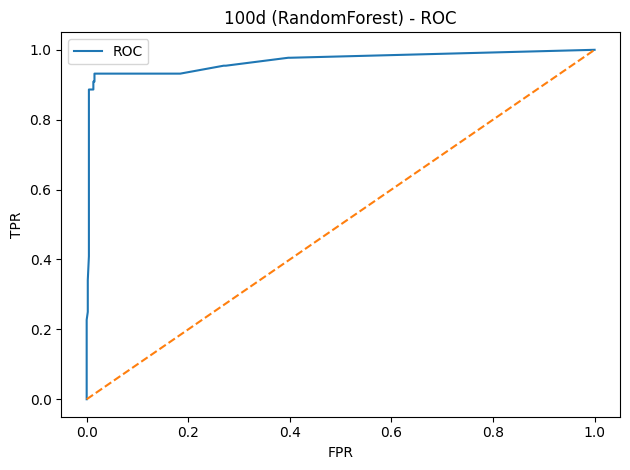

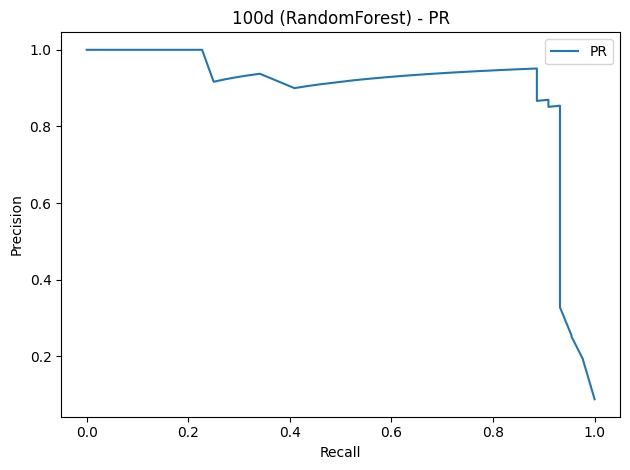

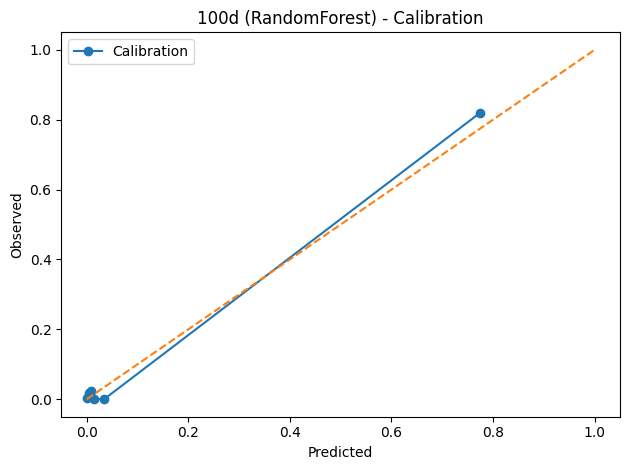


=== Horizon 1y (T=365) ===
Mean metrics over 5 folds:
 AUROC          0.797078
AUPRC          0.653332
Brier          0.127536
Accuracy       0.836957
Precision      0.804412
Recall         0.418182
F1             0.541840
BalancedAcc    0.693377
dtype: float64
Mean metrics over 5 folds:
 AUROC          0.797078
AUPRC          0.653332
Brier          0.127536
Accuracy       0.836957
Precision      0.804412
Recall         0.418182
F1             0.541840
BalancedAcc    0.693377
dtype: float64

Best model performances for horizon 1y:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419  0.982000   0.948718  0.840909  0.891566   
1y    0.795312  0.660395  0.127536  0.836957   0.807018  0.418182  0.550898   

      BalancedAcc  
100d     0.918262  
1y       0.693377  

Best model performances for horizon 1y:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419  0.982

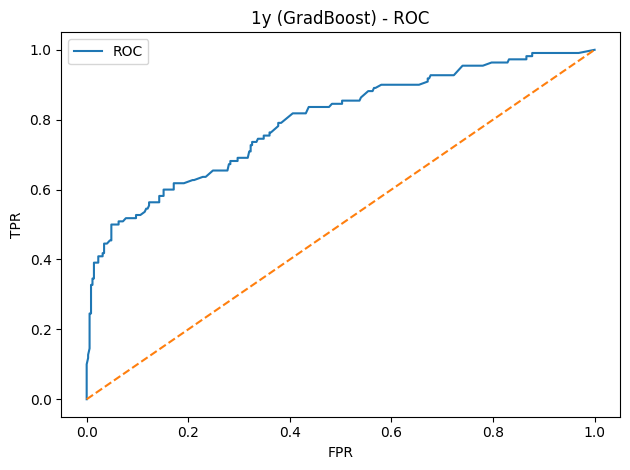

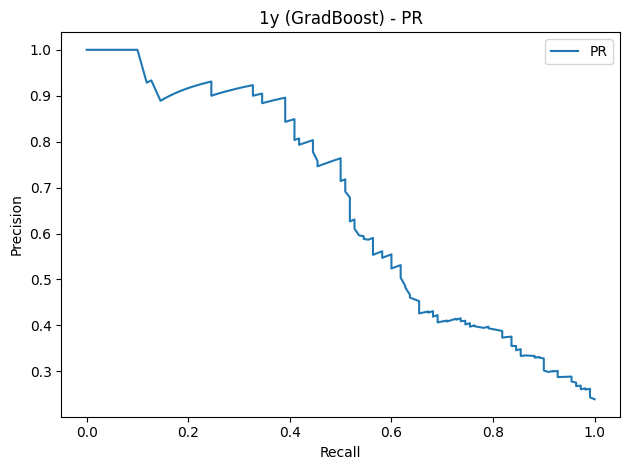

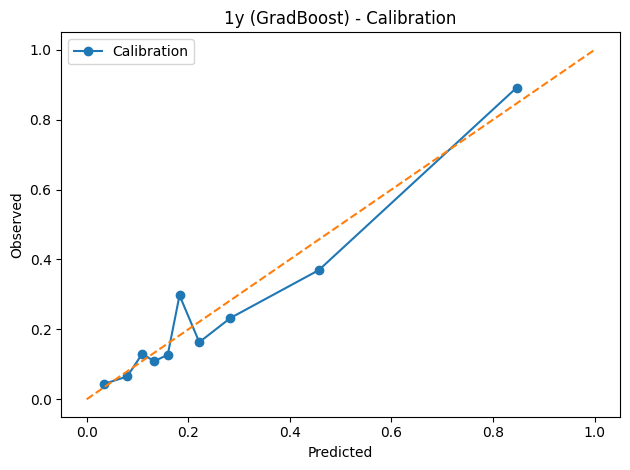


=== Horizon 2y (T=730) ===
Mean metrics over 5 folds:
 AUROC          0.766681
AUPRC          0.710708
Brier          0.181168
Accuracy       0.731418
Precision      0.718279
Recall         0.502989
F1             0.584773
BalancedAcc    0.687251
dtype: float64
Mean metrics over 5 folds:
 AUROC          0.766681
AUPRC          0.710708
Brier          0.181168
Accuracy       0.731418
Precision      0.718279
Recall         0.502989
F1             0.584773
BalancedAcc    0.687251
dtype: float64

Best model performances for horizon 2y:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419  0.982000   0.948718  0.840909  0.891566   
1y    0.795312  0.660395  0.127536  0.836957   0.807018  0.418182  0.550898   
2y    0.771549  0.712498  0.181143  0.731458   0.707547  0.503356  0.588235   

      BalancedAcc  
100d     0.918262  
1y       0.693377  
2y       0.687628  

Best model performances for horizon 2y:
          AUROC     AU

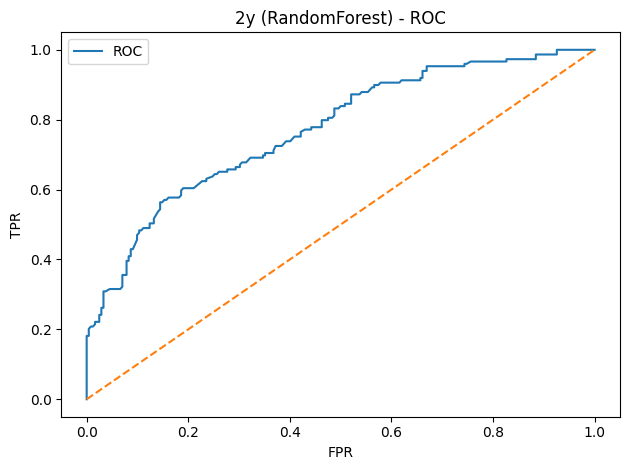

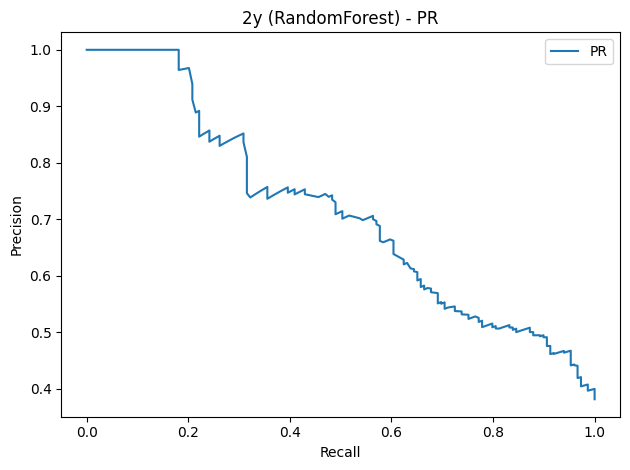

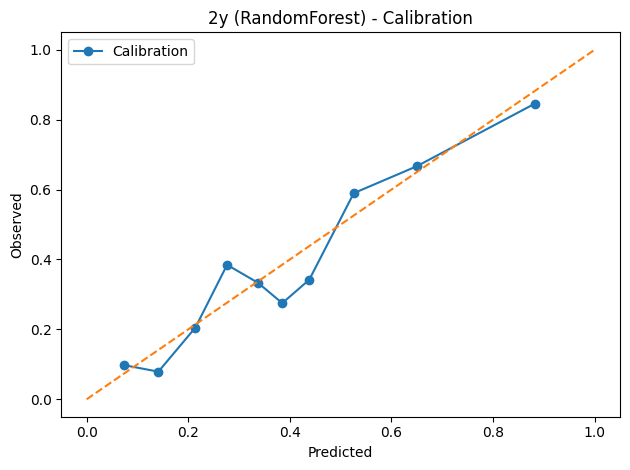


=== Horizon 3y (T=1095) ===
Mean metrics over 5 folds:
 AUROC          0.810460
AUPRC          0.827673
Brier          0.185343
Accuracy       0.724469
Precision      0.741545
Recall         0.693226
F1             0.711084
BalancedAcc    0.724510
dtype: float64
Mean metrics over 5 folds:
 AUROC          0.810460
AUPRC          0.827673
Brier          0.185343
Accuracy       0.724469
Precision      0.741545
Recall         0.693226
F1             0.711084
BalancedAcc    0.724510
dtype: float64

Best model performances for horizon 3y:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419  0.982000   0.948718  0.840909  0.891566   
1y    0.795312  0.660395  0.127536  0.836957   0.807018  0.418182  0.550898   
2y    0.771549  0.712498  0.181143  0.731458   0.707547  0.503356  0.588235   
3y    0.797906  0.814789  0.185323  0.724551   0.737179  0.692771  0.714286   

      BalancedAcc  
100d     0.918262  
1y       0.693377  
2y 

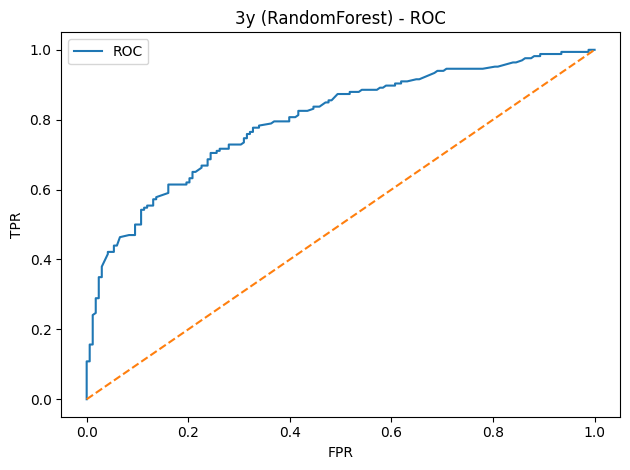

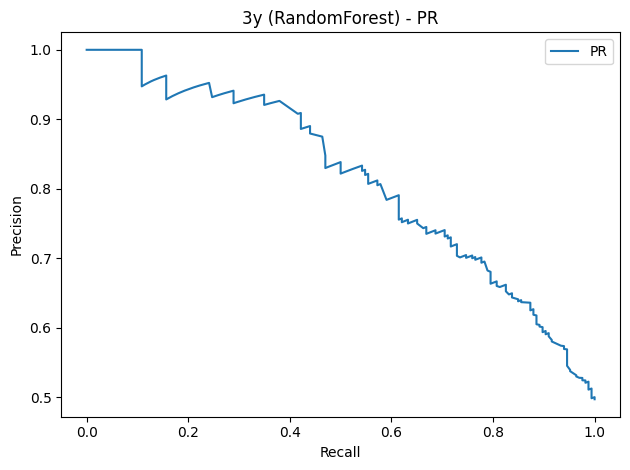

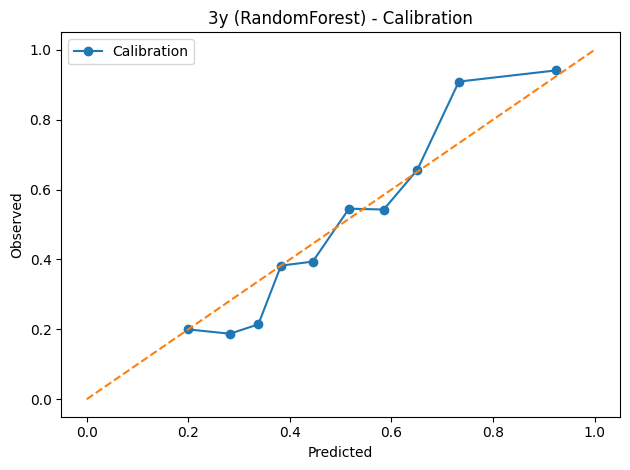

In [11]:
all_results = []
best_models = {}
best_model_performances = {}


for hname, T in HORIZONS.items():
    print(f'\n=== Horizon {hname} (T={T}) ===')
    y = make_labels(df, T)
    m = ~y.isna()
    Xh, yh = X[m], y[m].astype(int)

    pre = make_preprocessor(Xh)
    models, grids = make_models_and_grids()
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_metrics = []
    y_all_prob, y_all_true = [], []

    for k, (tr, te) in enumerate(outer.split(Xh, yh), start=1):
        Xtr, Xte = Xh.iloc[tr], Xh.iloc[te]
        ytr, yte = yh.iloc[tr], yh.iloc[te]

        best_auc, best_model = -np.inf, None
        for mname, clf in models.items():
            pipe = Pipeline([('prep', pre), ('clf', clf)])
            gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
            gs.fit(Xtr, ytr)
            cal = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
            cal.fit(Xtr, ytr)
            yprob = cal.predict_proba(Xte)[:,1]
            auc = roc_auc_score(yte, yprob)
            if auc > best_auc:
                best_auc, best_model = auc, cal

        yprob = best_model.predict_proba(Xte)[:,1]
        ypred = (yprob>=0.5).astype(int)
        metr = evaluate(yte, yprob, ypred); metr['Fold']=k; fold_metrics.append(metr)
        y_all_prob.extend(yprob.tolist()); y_all_true.extend(yte.tolist())

    res = pd.DataFrame(fold_metrics).mean(numeric_only=True)
    print('Mean metrics over 5 folds:\n', res[['AUROC','AUPRC','Brier','Accuracy','Precision','Recall','F1','BalancedAcc']])

    # Refit best family on all labeled data
    # Pick family by higher mean AUROC from the two models trained on full data with CV
    fam_scores = {}
    for mname, clf in models.items():
        pipe = Pipeline([('prep', pre), ('clf', clf)])
        gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
        gs.fit(Xh, yh)
        fam_scores[mname] = gs.best_score_
    best_family = max(fam_scores, key=fam_scores.get)
    gs = GridSearchCV(Pipeline([('prep', pre), ('clf', models[best_family])]), grids[best_family], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
    gs.fit(Xh, yh)
    cal_full = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
    cal_full.fit(Xh, yh)
    
    # for each best model, store its performance metrics like AUROC, AUPRC, etc. to plot later
    best_model_performances[hname] = evaluate(np.array(y_all_true), np.array(y_all_prob), (np.array(y_all_prob)>=0.5).astype(int))
    performance_df = pd.DataFrame.from_dict(best_model_performances, orient='index')
    print(f'\nBest model performances for horizon {hname}:\n', performance_df)
    

    joblib.dump(cal_full, f'outputs/best_model_{hname}.joblib')
    best_models[hname] = f'outputs/best_model_{hname}.joblib'

    plot_roc_pr_cal(np.array(y_all_true), np.array(y_all_prob), f'{hname} ({best_family})')

Creating confusion matrices using honest cross-validation predictions...
Note: These use test fold predictions that were never seen during training/tuning

=== 100d Horizon Confusion Matrix ===


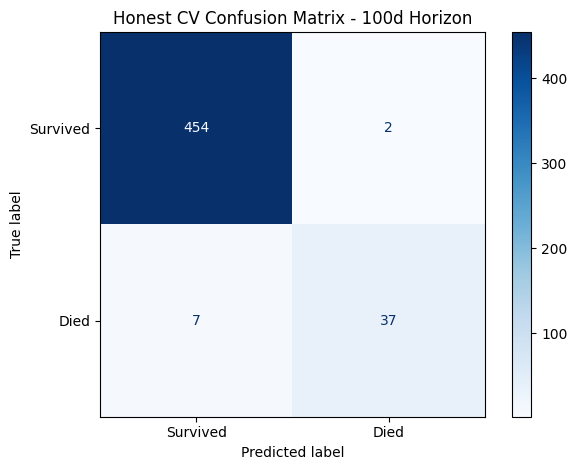

Classification Report for 100d:
              precision    recall  f1-score   support

    Survived       0.98      1.00      0.99       456
        Died       0.95      0.84      0.89        44

    accuracy                           0.98       500
   macro avg       0.97      0.92      0.94       500
weighted avg       0.98      0.98      0.98       500


Honest Performance Metrics:
AUROC: 0.968
Accuracy: 0.982
Precision: 0.949
Recall: 0.841
F1-Score: 0.892
--------------------------------------------------

=== 1y Horizon Confusion Matrix ===


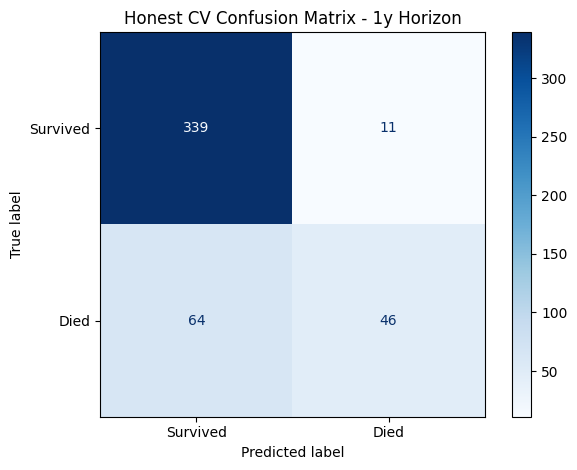

Classification Report for 1y:
              precision    recall  f1-score   support

    Survived       0.84      0.97      0.90       350
        Died       0.81      0.42      0.55       110

    accuracy                           0.84       460
   macro avg       0.82      0.69      0.73       460
weighted avg       0.83      0.84      0.82       460


Honest Performance Metrics:
AUROC: 0.795
Accuracy: 0.837
Precision: 0.807
Recall: 0.418
F1-Score: 0.551
--------------------------------------------------

=== 2y Horizon Confusion Matrix ===


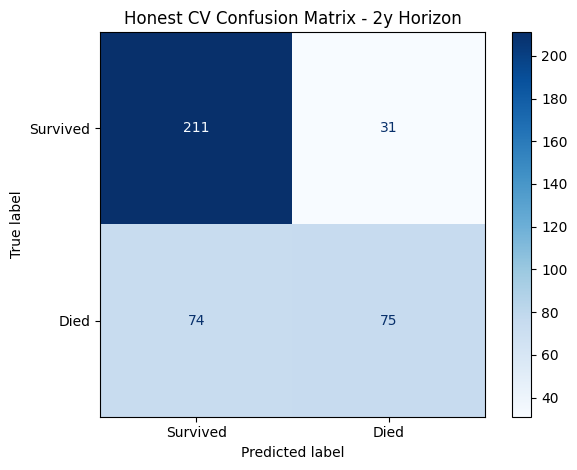

Classification Report for 2y:
              precision    recall  f1-score   support

    Survived       0.74      0.87      0.80       242
        Died       0.71      0.50      0.59       149

    accuracy                           0.73       391
   macro avg       0.72      0.69      0.69       391
weighted avg       0.73      0.73      0.72       391


Honest Performance Metrics:
AUROC: 0.772
Accuracy: 0.731
Precision: 0.708
Recall: 0.503
F1-Score: 0.588
--------------------------------------------------

=== 3y Horizon Confusion Matrix ===


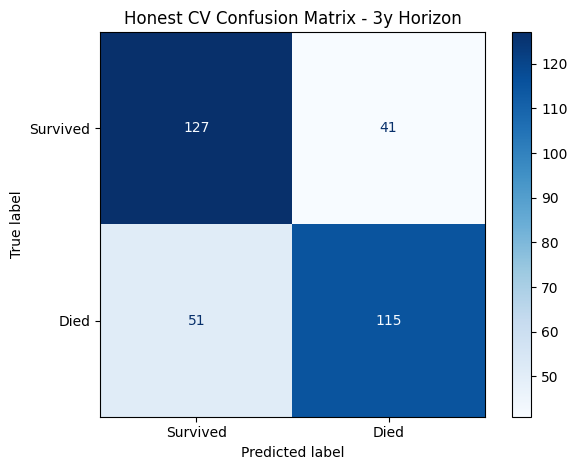

Classification Report for 3y:
              precision    recall  f1-score   support

    Survived       0.71      0.76      0.73       168
        Died       0.74      0.69      0.71       166

    accuracy                           0.72       334
   macro avg       0.73      0.72      0.72       334
weighted avg       0.73      0.72      0.72       334


Honest Performance Metrics:
AUROC: 0.798
Accuracy: 0.725
Precision: 0.737
Recall: 0.693
F1-Score: 0.714
--------------------------------------------------


In [26]:
# Plot confusion matrices using honest CV predictions
from sklearn.metrics import ConfusionMatrixDisplay

# We need to modify the training loop to save CV predictions for each horizon
# Let's create a version that saves the honest CV predictions

cv_predictions = {}  # Store CV predictions for each horizon

print("Creating confusion matrices using honest cross-validation predictions...")
print("Note: These use test fold predictions that were never seen during training/tuning")

for hname, T in HORIZONS.items():
    print(f'\n=== {hname} Horizon Confusion Matrix ===')
    y = make_labels(df, T)
    m = ~y.isna()
    Xh, yh = X[m], y[m].astype(int)

    pre = make_preprocessor(Xh)
    models, grids = make_models_and_grids()
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_cv_prob, y_cv_true = [], []

    # Recreate the CV predictions (same logic as training loop)
    for k, (tr, te) in enumerate(outer.split(Xh, yh), start=1):
        Xtr, Xte = Xh.iloc[tr], Xh.iloc[te]
        ytr, yte = yh.iloc[tr], yh.iloc[te]

        best_auc, best_model = -np.inf, None
        for mname, clf in models.items():
            pipe = Pipeline([('prep', pre), ('clf', clf)])
            gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', 
                            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
                            n_jobs=-1, refit=True)
            gs.fit(Xtr, ytr)
            cal = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
            cal.fit(Xtr, ytr)
            yprob = cal.predict_proba(Xte)[:,1]
            auc = roc_auc_score(yte, yprob)
            if auc > best_auc:
                best_auc, best_model = auc, cal

        # Collect honest test predictions
        yprob = best_model.predict_proba(Xte)[:,1]
        y_cv_prob.extend(yprob.tolist())
        y_cv_true.extend(yte.tolist())

    # Create confusion matrix from honest CV predictions
    y_cv_pred = (np.array(y_cv_prob) >= 0.5).astype(int)
    
    # Store for potential later use
    cv_predictions[hname] = {
        'y_true': y_cv_true, 
        'y_prob': y_cv_prob, 
        'y_pred': y_cv_pred
    }
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_cv_true, y_cv_pred, 
        cmap=plt.cm.Blues, 
        normalize=None,
        display_labels=['Survived', 'Died']
    )
    disp.ax_.set_title(f'Honest CV Confusion Matrix - {hname} Horizon')
    plt.tight_layout()
    plt.show()
    
    # Print some summary stats
    from sklearn.metrics import classification_report
    print(f"Classification Report for {hname}:")
    print(classification_report(y_cv_true, y_cv_pred, target_names=['Survived', 'Died']))
    
    # Performance metrics
    honest_metrics = evaluate(np.array(y_cv_true), np.array(y_cv_prob), y_cv_pred)
    print(f"\nHonest Performance Metrics:")
    print(f"AUROC: {honest_metrics['AUROC']:.3f}")
    print(f"Accuracy: {honest_metrics['Accuracy']:.3f}")
    print(f"Precision: {honest_metrics['Precision']:.3f}")
    print(f"Recall: {honest_metrics['Recall']:.3f}")
    print(f"F1-Score: {honest_metrics['F1']:.3f}")
    print("-" * 50)

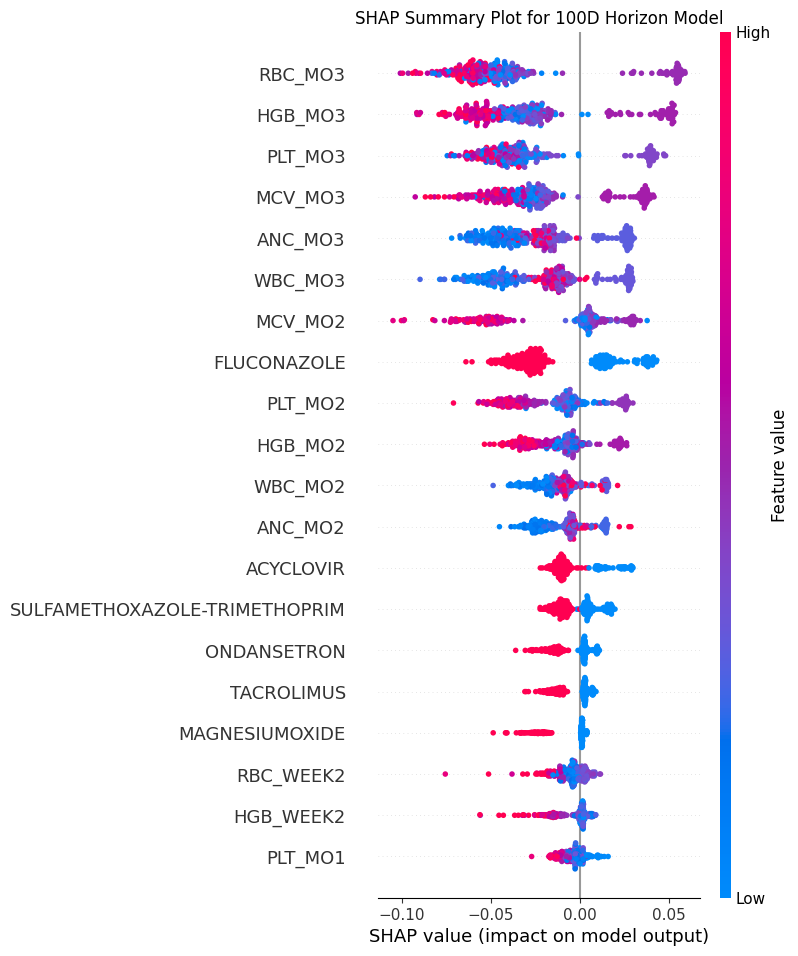

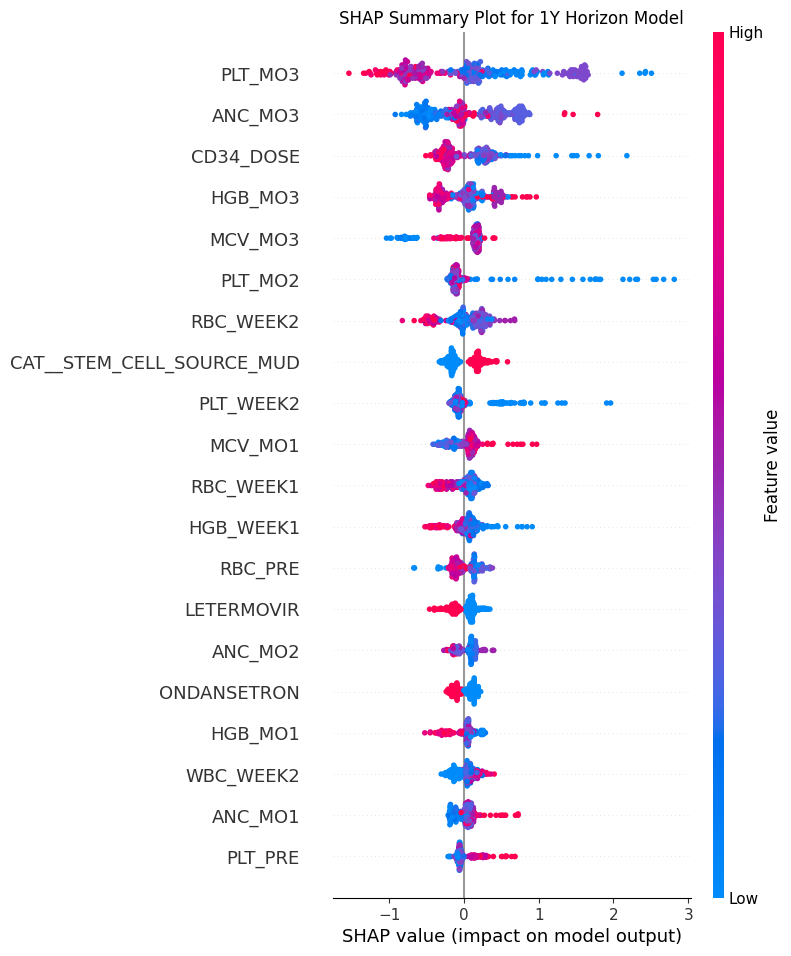

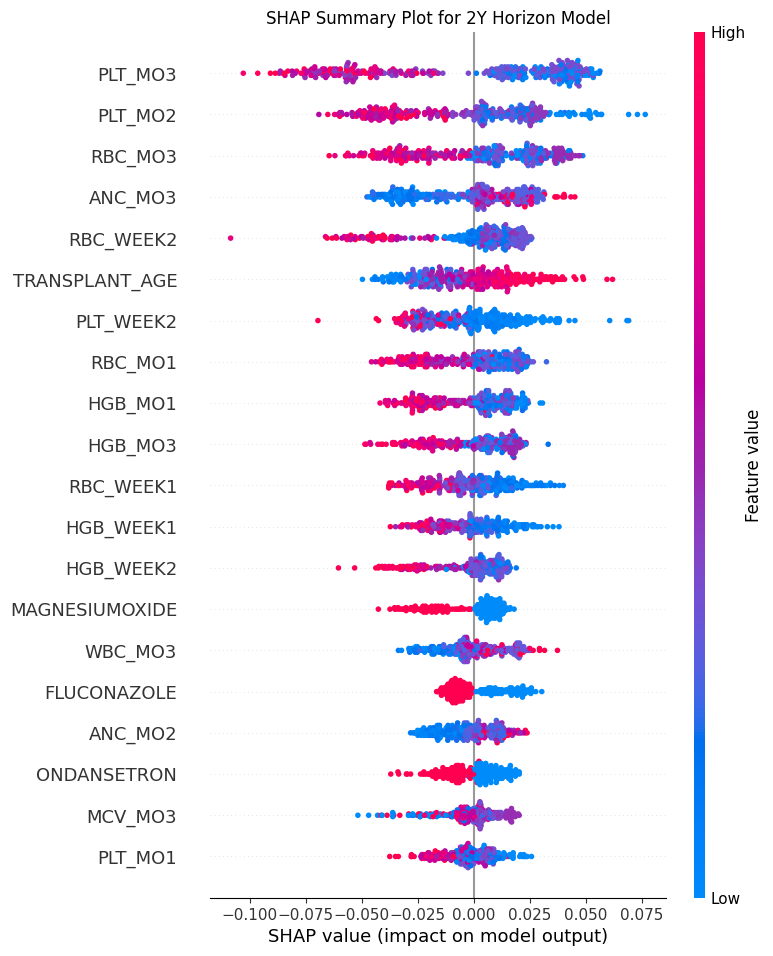

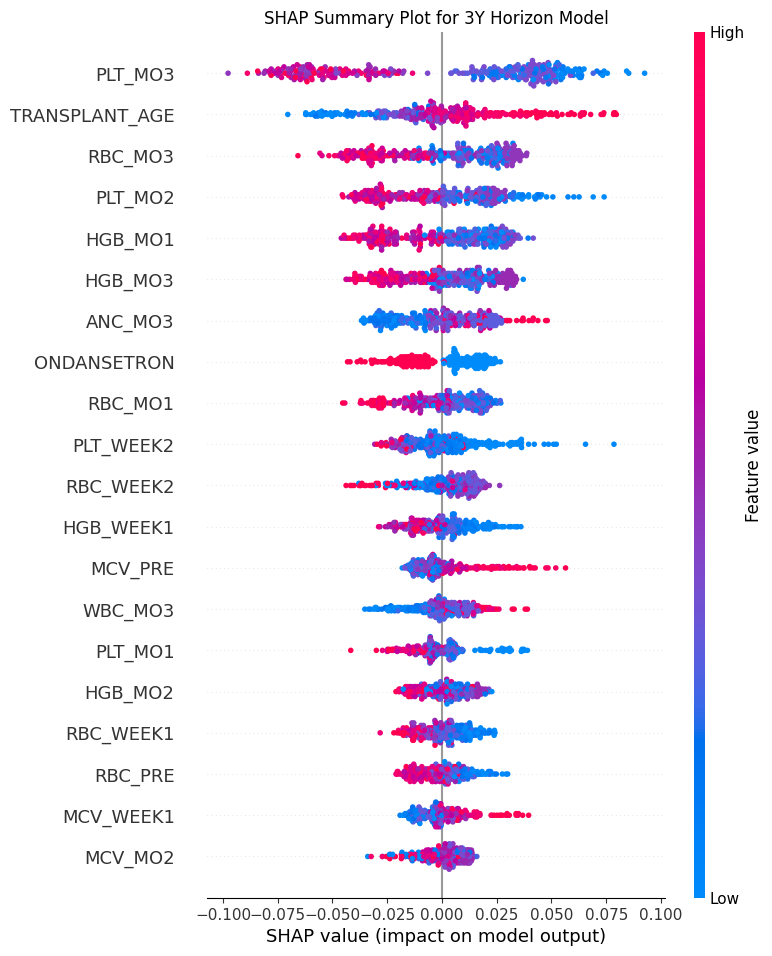

In [18]:
from allosurv.allosurv import plot_shap_for_horizon
# plot_shap_all_horizons

# Basic usage
# plot_shap_for_horizon(best_models, '3y', Xh)

# All horizons with bar charts
# plot_shap_all_horizons(best_models, Xh, plot_type='bar', max_display=15)

# Save individual plots
for horizon in ['100d', '1y', '2y', '3y']:
    plot_shap_for_horizon(best_models, horizon, Xh, 
                         )

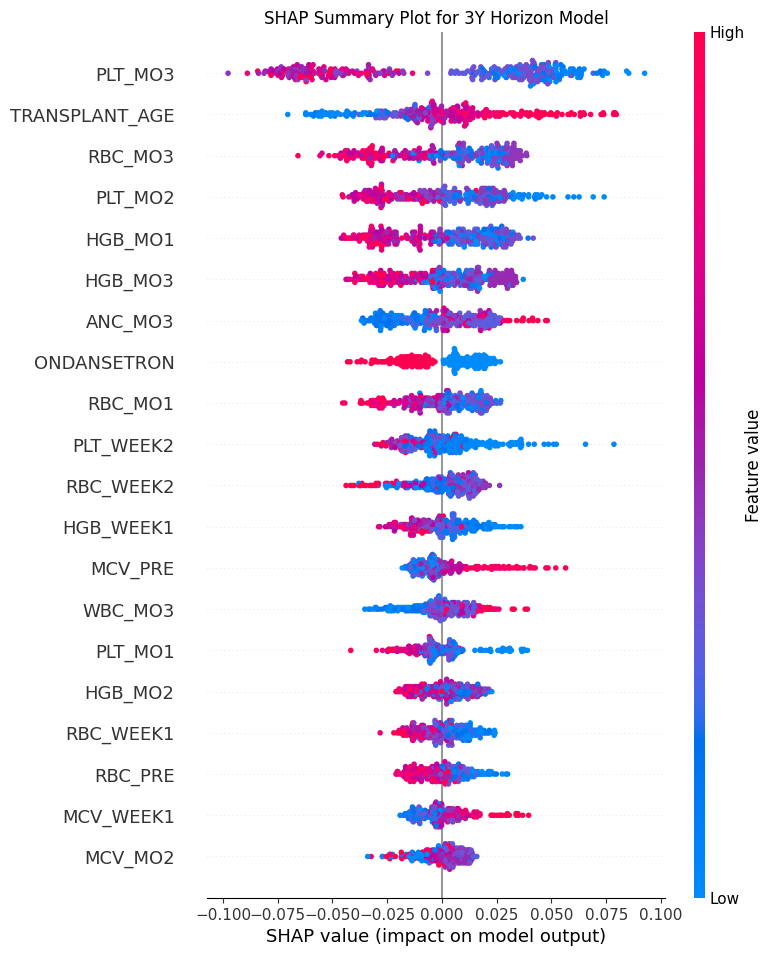

In [14]:
# perform shap analysis on the best model for 3y horizon
best_model_3y = joblib.load(best_models['3y'])
pipeline = best_model_3y.estimator
X_transformed = pipeline.named_steps['prep'].transform(Xh)

clf = pipeline.named_steps['clf']
if isinstance(clf, (RandomForestClassifier, GradientBoostingClassifier)):
    explainer = shap.TreeExplainer(clf)
else:
    explainer = shap.Explainer(clf, X_transformed)

shap_values = explainer(X_transformed)
feature_names = pipeline.named_steps['prep'].get_feature_names_out()
clean_feature_names = [name.replace('num__','').replace('cat__oh__','') for name in feature_names]
all_caps = [name.upper() for name in clean_feature_names]


shap_values_class1 = shap_values.values[:, :, 1]
shap.summary_plot(shap_values_class1, X_transformed, feature_names=all_caps, show=False, max_display=20)
plt.title('SHAP Summary Plot for 3Y Horizon Model')
plt.show()